# Optimizing with Transparency

This tutorial notebook illustrates how to use Captum.optim to render RGBA images when using models trained only on RGB images.  This process is known as optimizing with transparency, and more information on it can be found at [the corresponding research paper](https://distill.pub/2018/differentiable-parameterizations/#section-rgba). As we will see below, optimizing with transparency yields important information about the saliency of feature visualizations that regular feature visualizations misses.

In [ ]:
from typing import Callable, Tuple, List, Optional, Sequence, Union, Dict
import math
import torch
import torch.nn.functional as F

import captum.optim as opt
from captum.optim.models import googlenet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device)

We'll define four main helper functions for this tutorial. The first function allows us to create distinct checkerboard backgrounds that let us easily see transparency, and the second function allows for the compositing of RGBA images onto backgrounds. The third function allows us to quickly view RGBA images on multiple distinct backgrounds. The fourth function simply allows us to graph the loss values from our rendering.

In [ ]:
import matplotlib.pylab as plt


def create_checkerboard(
    size: Tuple[int, int],
    channels: int = 3,
    tiles: int = 4,
    colors: Tuple[float, float] = [1.0, 0.0],
) -> torch.Tensor:
    """
    Create a checkerboard pattern.

    Based on Lucid's checkerboard function from here: https://github.com/tensorflow/
    lucid/blob/master/notebooks/differentiable-parameterizations/transparency.ipynb

    Args:

        size (Tuple[int, int]): The dimensions to use when creating the image, with a
            shape of: [H, W].
        channels (int, optional): The number of image channels to use for the output
            image.
            Default: 3
        tiles (int, optional): The number of tiles to create inside the image.
            Default: 4
        colors (Tuple[float, float], optional): A tuple of colors to use for the
            checkerboard.
            Default: (1.0, 0.0)

    Returns:
        tensor (torch.Tensor): An NCHW image with a checkerboard pattern.
    """
    assert len(size) == 2 and len(colors) == 2

    square = torch.ones([math.ceil(float(d / tiles) / 2) for d in size])
    board = torch.tensor([colors * tiles, colors[::-1] * tiles] * tiles)
    scaled = torch.kron(board, square)[: size[1], : size[0]]
    return torch.stack([scaled] * channels)


def composite_alpha(
    x: torch.Tensor,
    background: torch.Tensor,
    gamma_to_linear: bool = False,
    linear_to_gamma: bool = True,
) -> torch.Tensor:
    """
    Composite an RGBA NCHW image tensor onto an NCHW image tensor background.

    See here for more details:
    https://en.wikipedia.org/wiki/Alpha_compositing
    https://en.wikipedia.org/wiki/Alpha_compositing#Gamma_correction

    Args:

        x (torch.Tensor): The RGBA image tensor with 4 channels in the format of NCHW.
        background (torch.Tensor): The background NCHW image tensor to use.
        gamma_to_linear (bool, optional): Whether or not to convert the alpha channel
            of the input image from gamma to a linear format.
            Default: False
        linear_to_gamma (bool, optional): Whether or not to convert the output image
            from linear to gamma format.
            Default: True

    Returns:
        image (torch.Tensor): The input image composited on top of the background.
    """
    assert x.dim() == 4 and x.shape[1] == 4
    assert background.dim() == 4
    assert x.device == background.device
    if gamma_to_linear:
        x[:, :3, ...] = x[:, :3, ...].clone() ** 2.2
    rgb, alpha_channel = x[:, :3, ...], x[:, 3:, ...]
    image = background * (1.0 - alpha_channel) + rgb * alpha_channel
    if linear_to_gamma:
        image = image ** (1.0 / 2.2)
    return image


def create_mosaic(
    img: torch.Tensor, background: Optional[torch.Tensor] = None
) -> torch.Tensor:
    """
    Composite an NCHW RGBA image tensor onto 4 distinct backgrounds;
    no background, custom, white, and black backgrounds.

    Args:

        img (torch.Tensor): An RGBA NCHW image tensor.
        background (torch.Tensor, optional): An NCHW image tensor to use as a
             background for the img input.

    Returns:
        mosaic_tensor (torch.Tensor): An NCHW image mosaic showing the img
            input on different backgrounds.
    """
    assert img.dim() == 4 and img.shape[1] == 4
    img_list = [img[:, :3]]

    # Place visualizations on top of our background image
    if background is not None:
        img_list.append(composite_alpha(img, background))

    # Place visualization on white background
    img_list.append(composite_alpha(img, torch.ones_like(img[:, :3])))

    # Place visualization on black background
    img_list.append(composite_alpha(img, torch.zeros_like(img[:, :3])))
    return torch.cat(img_list)


def composite_alpha_only(x: torch.Tensor) -> torch.Tensor:
    """
    Visualize the alphs channel of an NCHW RGBA image tensor.

    Args:

        x (torch.Tensor): An RGBA NCHW image tensor.

    Returns:
        x (torch.Tensor): An RGB NCHW image tensor for the 4th input image channel.
    """
    assert x.dim() == 4 and x.shape[1] == 4
    return torch.ones_like(x[:, :3]) * x[:, 3:]


def plot_loss(
    history: Union[torch.Tensor, List[torch.Tensor]],
    figsize: Optional[Tuple[int, int]] = None,
    title: Optional[str] = None,
    labels: Optional[List[str]] = None,
    axis_names: Optional[List[str]] = ["Step", "Loss"],
) -> None:
    """
    Helper function for graphing losses.

    Args:

        history (torch.Tensor or list of torch.Tensor): A set of loss values inside
            the history created from the optimize function.
        figsize (Tuple[int, int], optional): The size of the graph.
            Default: None
        title (str, optional): The title of the graph.
            Default: None
        labels (list of str, optional): A list labels to use if graphing multiple
            history tensors.
            Default: None
        axis_names (list of str): The names to use for the x and y axes, in a format
            of: [x_axis, y_axis].
            Default: ["Step", "Loss"]
    """
    assert len(axis_names) == 2
    if figsize is not None:
        plt.figure(figsize=figsize)
    if not torch.is_tensor(history):
        history = [h.detach().cpu().tolist() for h in history]
        for i, h in enumerate(history):
            label = "Test " + str(i + 1) if labels is None else labels[i]
            plt.plot(h, label=label)
        plt.legend()
    else:
        history = history.detach().cpu().tolist()
        plt.plot(history)
    if title is not None:
        plt.title(title)
    if axis_names is not None:
        plt.ylabel(axis_names[1])
        plt.xlabel(axis_names[0])
    plt.show()

### Basic Optimization Without Transparency

Below we'll start off by performing feature visualization without any sort of transparency.

  0%|          | 0/512 [00:00<?, ? step/s]

  0%|          | 0/256 [00:00<?, ? step/s]

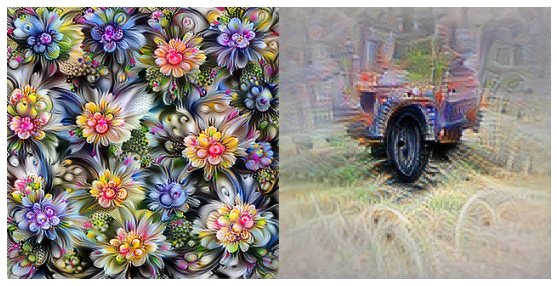

In [ ]:
def vis_one_stage_no_alpha(
    model: torch.nn.Module,
    loss_fn: opt.loss.Loss,
    size: Tuple[int, int],
    n_iter: int = 512,
    lr: float = 0.024
) -> torch.Tensor:
    image = opt.images.NaturalImage(size, channels=3).to(device)

    # Setup basic transforms to apply to every test
    transforms = opt.transforms.TransformationRobustness()
    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(opt.optimization.n_steps(n_iter, True), lr=lr)
    return image().detach()


# Set channel optimization target & render visualization
loss_fn = opt.loss.ChannelActivation(model.mixed4d.conv_3x3_reduce, channel_index=139)
img_channel = vis_one_stage_no_alpha(model, loss_fn, (320, 320), n_iter=512)

# Set neuron optimization target & render visualization
loss_fn = opt.loss.NeuronActivation(model.mixed4b, channel_index=373)
img_neuron = vis_one_stage_no_alpha(model, loss_fn, (200, 200), n_iter=256, lr=0.01)

# Show both visualizations side by side
img_neuron = F.interpolate(img_neuron, size=(320, 320))
img_no_alpha = torch.cat([img_channel, img_neuron])
opt.images.show(img_no_alpha, figsize=(10, 5))

Looking at the above flower and car tire visualizations, we have no way of determining the importance of each part of the visualization. For example, we cannot easily tell what part of the flower is most important or how important the car body and ground are for tire detection.

This limitation of feature visualization may seem like something unavoidable, however it can be overcome with some clever design!

**Optimizing Additional Degrees of Freedom**

* Feature visualization can yield a ton of information about a target, but by default is unable to work with some of the additional degrees of freedom that targets can have. One such area is the importance or saliency of each part of the visualization. In the case of a model trained on 3 channel RGB images, we can view this additional dimension by adding a 4th channel for alpha transparency to our image parameterization. 

## Alpha Channel / Transparency

**Optimizing With The Additional Alpha Channel**

* Using the 4 channel RGBA image parameterization allows us to see the feature importance based on opacity. The more opaque something is, the more important it is. The more transparent something is, the less important it is.

* The optim module has been designed so that using RGBA images is just as easy as RGB images. For example, `NaturalImage()` handles RGBA images without any changes, other than being initialized with `channels=4`.

* To render a 4 channel visualization using a model that only supports 3 channels, we can use Captum's `BlendAlpha()` on our model input as the final transform. The `BlendAlpha()` transform performs [alpha composing](https://en.wikipedia.org/wiki/Alpha_compositing) which turns the 4 channel RGBA image into a 3 channel RGB image.

Below we have created a helper function for visualizing single stage optimization with transparency.

In [ ]:
def vis_one_stage(
    model: torch.nn.Module,
    loss_fn: opt.loss.Loss,
    image: opt.images.ImageParameterization,
    additional_transforms: Optional[List[torch.nn.Module]] = None,
    n_iter: int = 512,
) -> torch.Tensor:
    assert image().dim() == 4 and image().shape[1] == 4

    # Setup basic transforms to apply to every test
    transforms = [opt.transforms.TransformationRobustness()]

    if additional_transforms is not None:
        transforms = transforms + additional_transforms
    obj = opt.InputOptimization(model, loss_fn, image, torch.nn.Sequential(*transforms))
    history = obj.optimize(opt.optimization.n_steps(n_iter, True), lr=0.01)
    return image().detach(), history

### Basic optimization with transparency


For basic optimization with transparency, we use a simple self balancing equation that avoids producing too much transparency or too much opaqueness:

```
loss_fn = LossFunction * (1.0 - mean(alpha_channel))
```

The above equation's alpha channel portion can be performed by using Captum's `opt.loss.ChannelLoss` objective with a channel index of `4` for the alpha channel and `opt.images.NaturalImage` as the target. This is demonstrated below.

  0%|          | 0/512 [00:00<?, ? step/s]

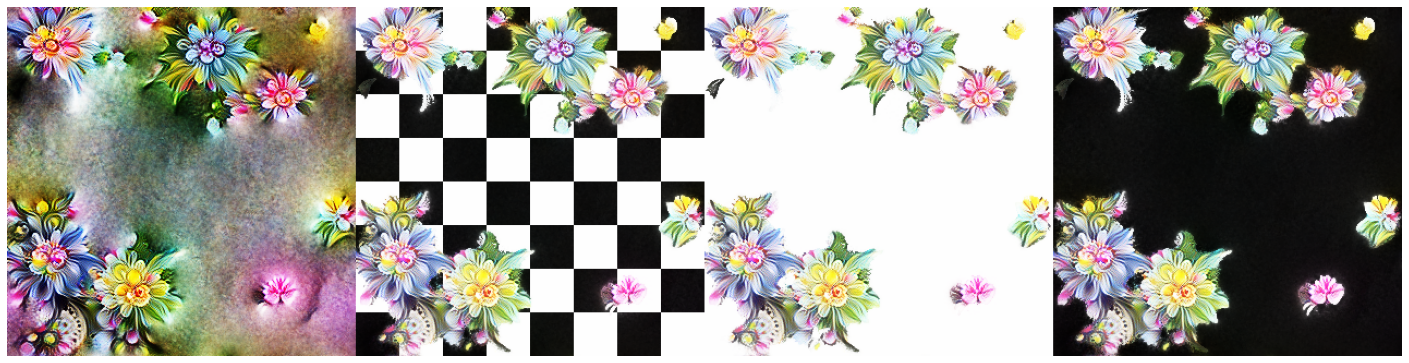

In [ ]:
image_size = (320, 320)

# Initialize NaturalImage with 4 channels
image = opt.images.NaturalImage(image_size, channels=4).to(device)

# Set optimization target
loss_fn = opt.loss.ChannelActivation(model.mixed4d.conv_3x3_reduce, channel_index=139)

#  Use NaturalImage output as target, and collect alpha channel for mean()
loss_fn = loss_fn * (1.0 - opt.loss.ChannelActivation(image, channel_index=3))

# Create a background image
background = create_checkerboard(image_size, tiles=4).unsqueeze(0).to(device)

# Blend the alpha channel into the image as our final transform
transforms = [opt.transforms.BlendAlpha()]

# Render the visualization
img_basic, history_basic = vis_one_stage(
    model, loss_fn, image, additional_transforms=transforms, n_iter=512
)

# Show visualization on multiple backgrounds
# The backgrounds are as follows: No transparency, checkerboard, white, & black
opt.images.show(create_mosaic(img_basic, background), figsize=(25, 10))

By placing our rendered image onto different backgrounds, we can clearly see the varying degrees of transparency throughout the image.


We can also see that the optimization process is working well with our setup, by using the `plot_loss` helper function on the `history` output of `InputOptimization`'s `optimize` function.

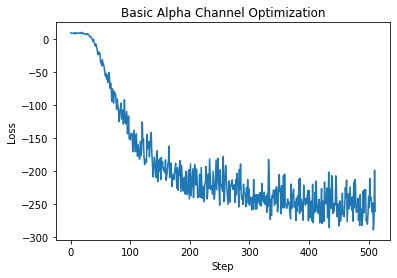

In [ ]:
# Plot loss vs iterations
plot_loss(history_basic, title="Basic Alpha Channel Optimization")

## Advanced optimization with transparency


While the simple optimization above using `opt.loss.ChannelLoss` works for optimizing the alpha channel, we can do better in a variety of ways. For example, using `NaturalImage` as a target means that we miss out on the random image transforms that can improve visualization quality.

Below we define a special loss objective for optimizing our alpha channel, using transform robustness. We also add a `CenterCrop()` transform to encourage the visualization to avoid the edges of the image.

In [ ]:
ModuleOutputMapping = Dict[torch.nn.Module, Optional[torch.Tensor]]

@opt.loss.loss_wrapper
class AlphaChannelLoss(opt.loss.BaseLoss):
    """
    Optimize the alpha channel of an image parameterization.
    """

    def __init__(
        self,
        target: torch.nn.Module,
        crop_size: Tuple[int, int],
        scale_list: List[float],
        scale: int = 1.0,
        batch_index: Optional[int] = None,
    ) -> None:
        """
        Args:

            crop_size (Tuple[int, int]): The desired random crop size to use.
            scale_list (list of float): A list of scale values to randomly select from
                when rescaling the input.
            scale (float, optional): The maximum value in the image value range.
                Default: 1.0
            batch_index (int, optional): The target batch index to use.
                Default: None
        """
        opt.loss.BaseLoss.__init__(self, target, batch_index)
        assert len(crop_size) == 2
        self.random_scale = opt.transforms.RandomScale(scale_list)
        self.random_crop = opt.transforms.RandomCrop(crop_size=crop_size)
        self.scale = scale

    def __call__(self, targets_to_values: ModuleOutputMapping) -> torch.Tensor:
        activations = targets_to_values[self.target]
        activations = activations[self.batch_index[0] : self.batch_index[1], :, ...]
        assert activations.dim() == 4
        assert activations.shape[1] == 4

        alpha_mean = activations[:, 3:, ...].clone().mean()

        # Randomly scale the image and then randomly crop it
        scaled_alpha = self.random_scale(activations[:, 3:, ...].clone())
        cropped_alpha_mean = self.random_crop(scaled_alpha).mean()
        
        loss = (self.scale - alpha_mean) * (self.scale / 2)
        return loss + (self.scale - cropped_alpha_mean)

Now we can render the results using the `AlphaChannelLoss()` objective!

  0%|          | 0/512 [00:00<?, ? step/s]

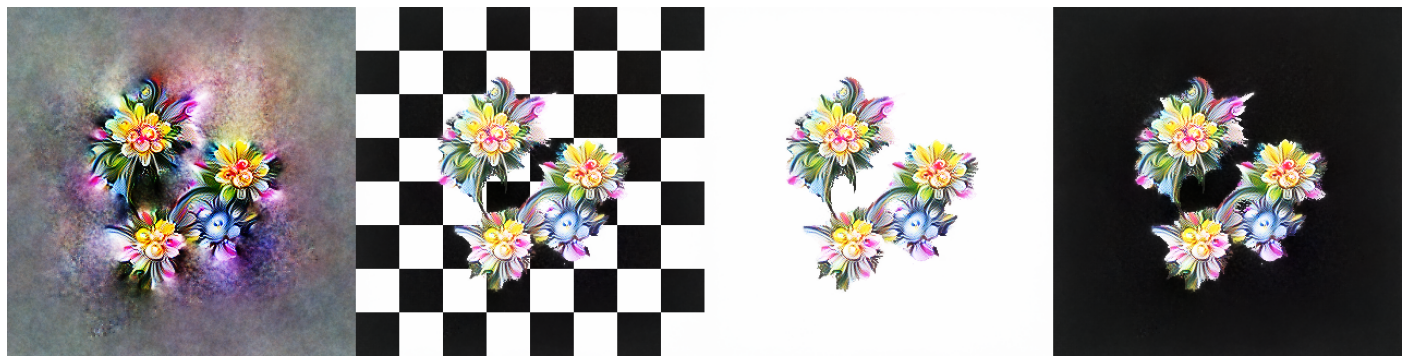

In [ ]:
image_size = (320, 320)
crop_size = (160, 160)
scale_list = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

# Initialize NaturalImage with 4 channels
image = opt.images.NaturalImage(image_size, channels=4).to(device)

# Set optimization target
loss_fn = opt.loss.ChannelActivation(model.mixed4d.conv_3x3_reduce, channel_index=139)

#  Use NaturalImage output as target, for alpha channel loss objective
loss_fn = loss_fn * AlphaChannelLoss(image, crop_size=crop_size, scale_list=scale_list)

# Create background image
background = create_checkerboard(image_size, tiles=4).unsqueeze(0).to(device)

# Blend the alpha channel into the image using random backgrounds &
# center crop the image to encourage visualizations in the image center
transforms = [opt.transforms.BlendAlpha(), opt.transforms.CenterCrop(crop_size)]

# Render visualization
img_advanced, history_advanced = vis_one_stage(
    model, loss_fn, image, additional_transforms=transforms, n_iter=512
)

# Show visualization on multiple backgrounds
# The backgrounds are as follows: No transparency, checkerboard, white, & black
opt.images.show(create_mosaic(img_advanced, background), figsize=(25, 10))

When we look at the history graph, we can see that the optimization process performed even better with our improved `AlphaChannelLoss()` objective!

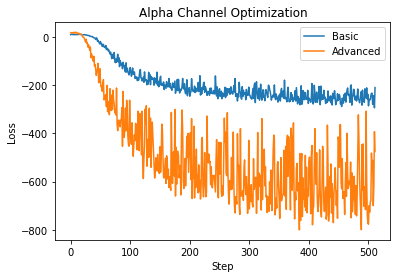

In [ ]:
# Plot loss vs iterations & previous loss
plot_loss(
    history=[history_basic, history_advanced],
    title="Alpha Channel Optimization",
    labels=["Basic", "Advanced"],
)

## Two Stage Optimization with Transparency

In addition to using the `BlendAlpha()` transform for RGBA images, we can also simply cut off and ignore the alpha channel by using the `IgnoreAlpha()` transform. This is useful for example when we want to ignore the alpha channel for the first step of two step optimization, so that the first stage of optimization occurs without the influence of the alpha channel.

Below we define a helper function for two stage optimization with transparency.

In [ ]:
def vis_two_stage(
    model: torch.nn.Module,
    loss_fn: opt.loss.Loss,
    image: opt.images.ImageParameterization,
    tranforms_two: Optional[List[torch.nn.Module]] = None,
    n_iter_one: int = 256,
    n_iter_two: int = 512,
    advanced_alpha_loss: bool = True,
) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    assert image().dim() == 4 and image().shape[1] == 4
    imgs, losses = [], []

    # Setup basic transforms to apply to every test
    basic_transforms = [opt.transforms.TransformationRobustness()]

    # Ignore the alpha channel for stage 1 optimization
    transforms = basic_transforms + [opt.transforms.IgnoreAlpha()]
    obj = opt.InputOptimization(model, loss_fn, image, torch.nn.Sequential(*transforms))
    history = obj.optimize(opt.optimization.n_steps(n_iter_one, True), lr=0.01)

    # Add stage 1 to our lists
    imgs.append(image().clone().detach())
    losses.append(history)

    # Add BlendAlpha() transform for stage 2 optimization
    if tranforms_two is not None:
        transforms = basic_transforms + tranforms_two

    #  Use NaturalImage output as target for alpha channel loss objective
    if advanced_alpha_loss:
        scale_list = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
        loss_fn = loss_fn * AlphaChannelLoss(
            image, crop_size=(60, 60), scale_list=scale_list
        )
    else:
        loss_fn * (1 - opt.loss.ChannelActivation(image, channel_index=3))

    obj = opt.InputOptimization(model, loss_fn, image, torch.nn.Sequential(*transforms))
    history = obj.optimize(opt.optimization.n_steps(n_iter_two, True), lr=0.01)

    # Add stage 2 to our lists
    imgs.append(image().clone().detach())
    losses.append(history)

    return imgs, losses

We can then perform two stage optimization with transparency like so.

  0%|          | 0/256 [00:00<?, ? step/s]

  0%|          | 0/512 [00:00<?, ? step/s]

Stage 1 Visualization (No Alpha Channel)


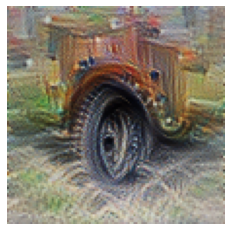

Stage 2 Visualization


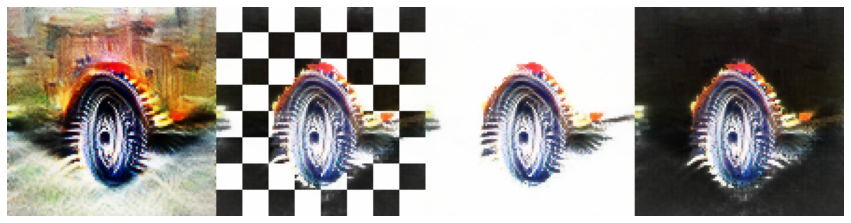

In [ ]:
image_size = (112, 112)

# Initialize NaturalImage with 4 channels
image = opt.images.NaturalImage(image_size, channels=4).to(device)

# Other targets to explore
# target=model.mixed3a.conv_3x3; channel_index=76
# target=model.mixed3a.conv_3x3_reduce_relu; channel_index=76 - 64
# target=model.mixed4d.conv_3x3_reduce; channel_index=139

# Car Tire
target = model.mixed4b
channel_index = 373

# Set optimization target
loss_fn = opt.loss.NeuronActivation(target, channel_index=channel_index)

# Create background image
background = create_checkerboard(image_size, tiles=4).unsqueeze(0).to(device)

# Blend the alpha channel into the image
transforms = [opt.transforms.BlendAlpha()]

# Render visualizations
imgs, histories = vis_two_stage(
    model,
    loss_fn,
    image,
    tranforms_two=transforms,
    n_iter_one=256,
    n_iter_two=512,
    advanced_alpha_loss=True,
)

# Show step 1 image without alpha channel
print("Stage 1 Visualization (No Alpha Channel)")
opt.images.show(imgs[0][:, :3, ...])

# Show visualization on multiple backgrounds
print("Stage 2 Visualization")
opt.images.show(create_mosaic(imgs[1], background), figsize=(15, 10))

And we can see the loss graph for both stages like so:

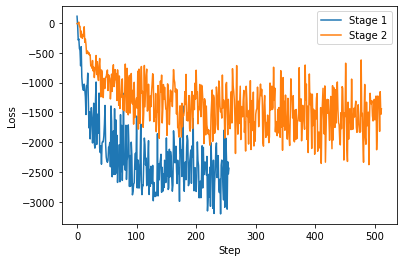

In [ ]:
# Plot loss vs iterations
plot_loss(histories, labels=["Stage 1", "Stage 2"])

### Single Stage vs Two Stage Comparison

We can also see how single stage optimization compares to two stage optimization.

  0%|          | 0/512 [00:00<?, ? step/s]

Single Stage Visualization


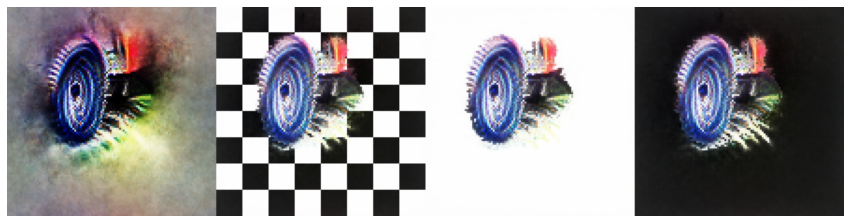

Two Stage Visualization


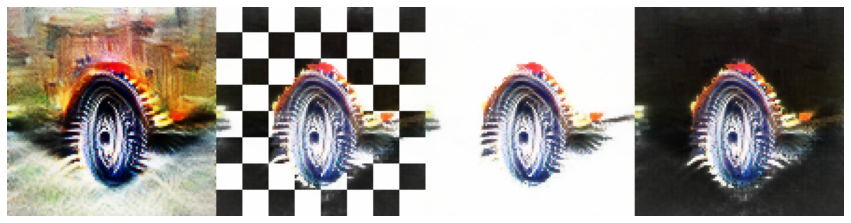

In [ ]:
image_size = (112, 112)
crop_size = (60, 60)
scale_list = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

# Initialize NaturalImage with 4 channels
image = opt.images.NaturalImage(image_size, channels=4).to(device)

# Set optimization target
target = model.mixed4b
channel_index = 373

loss_fn = opt.loss.NeuronActivation(target, channel_index=channel_index)

#  Use NaturalImage output as target, for alpha channel loss objective
loss_fn = loss_fn * AlphaChannelLoss(image, crop_size=crop_size, scale_list=scale_list)

# Create background image
background = create_checkerboard(image_size, tiles=4).unsqueeze(0).to(device)

# Blend the alpha channel into the image using random backgrounds &
# center crop the image to encourage visualizations in the image center
transforms = [opt.transforms.BlendAlpha(), opt.transforms.CenterCrop(crop_size)]

# Render visualization
neuron_img, history_advanced = vis_one_stage(
    model, loss_fn, image, additional_transforms=transforms, n_iter=512
)

# Show single stage visualization on multiple backgrounds
print("Single Stage Visualization")
opt.images.show(create_mosaic(neuron_img, background), figsize=(15, 10))

# Show two stage visualization on multiple backgrounds
print("Two Stage Visualization")
opt.images.show(create_mosaic(imgs[1], background), figsize=(15, 10))

You can see that using two stage visualization can help reveal important areas of the visualization that the single stage misses.